In [1]:
from cmdstanpy import CmdStanModel 
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import stan

/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [428]:
data = pd.read_csv('./cars.csv')
data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900
5,5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Warszawa,Mazowieckie,51900
6,6,opel,combo,gen-d-2011,2017,119965,1248,Diesel,Wrocław,Dolnośląskie,44700
7,7,opel,combo,gen-d-2011,2016,201658,1248,Diesel,Lublin,Lubelskie,29000
8,8,opel,combo,gen-d-2011,2014,178666,1598,Diesel,Złotów,Wielkopolskie,28900
9,9,opel,combo,gen-d-2011,2015,113000,1248,Diesel,Strzyżew,Mazowieckie,34900


In [429]:
print(data.mark.unique())

['opel' 'audi' 'bmw' 'volkswagen' 'ford' 'mercedes-benz' 'renault'
 'toyota' 'skoda' 'alfa-romeo' 'chevrolet' 'citroen' 'fiat' 'honda'
 'hyundai' 'kia' 'mazda' 'mini' 'mitsubishi' 'nissan' 'peugeot' 'seat'
 'volvo']


In [430]:
data = data.loc[(data['mark'] == 'mazda') | (data['mark'] == 'toyota') | (data['mark'] == 'nissan') ]
data

# data - volvo najlepszy

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
69639,69639,toyota,auris,gen-ii-2012,2015,90229,1798,Hybrid,Warszawa,Mazowieckie,64500
69640,69640,toyota,auris,gen-ii-2012,2016,114455,1598,Gasoline,Łódź,Łódzkie,56000
69641,69641,toyota,auris,gen-ii-2012,2015,100000,1598,Gasoline,Radom,Mazowieckie,47900
69642,69642,toyota,auris,gen-ii-2012,2018,60066,1598,LPG,Katowice,Śląskie,76501
69643,69643,toyota,auris,gen-ii-2012,2018,54500,1329,Gasoline,Piaseczno,Mazowieckie,54000
...,...,...,...,...,...,...,...,...,...,...,...
105634,105634,nissan,x-trail,gen-iii-2014-x-trail,2016,94200,1598,Diesel,Jemielnica,Opolskie,61800
105635,105635,nissan,x-trail,gen-iii-2014-x-trail,2018,43000,1598,Diesel,Marki,Mazowieckie,89999
105636,105636,nissan,x-trail,gen-iii-2014-x-trail,2015,160000,1598,Diesel,Kielce,Świętokrzyskie,59000
105637,105637,nissan,x-trail,gen-iii-2014-x-trail,2015,217000,1598,Diesel,Płock,Mazowieckie,63500


In [431]:
 # Standarizing Age, Bmi and Charges columns
mean_mileage = data.mileage.mean()
std_mileage = data.mileage.std()
data.mileage = (data.mileage-mean_mileage)/std_mileage


# bmi
mean_vol_engine = data.vol_engine.mean()
std_vol_engine = data.vol_engine.std()
data.vol_engine = (data.vol_engine-mean_vol_engine)/std_vol_engine

mean_price = data.price.mean()
std_price = data.price.std()
data.price = (data.price-mean_price)/std_price
data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
69639,69639,toyota,auris,gen-ii-2012,2015,-0.434863,0.173747,Hybrid,Warszawa,Mazowieckie,0.270524
69640,69640,toyota,auris,gen-ii-2012,2016,-0.139843,-0.260610,Gasoline,Łódź,Łódzkie,0.053394
69641,69641,toyota,auris,gen-ii-2012,2015,-0.315874,-0.260610,Gasoline,Radom,Mazowieckie,-0.153517
69642,69642,toyota,auris,gen-ii-2012,2018,-0.802183,-0.260610,LPG,Katowice,Śląskie,0.577086
69643,69643,toyota,auris,gen-ii-2012,2018,-0.869965,-0.844821,Gasoline,Piaseczno,Mazowieckie,0.002305
69644,69644,toyota,auris,gen-ii-2012,2018,-0.582410,0.173747,Hybrid,Janki,Mazowieckie,0.766091
69645,69645,toyota,auris,gen-ii-2012,2016,-0.064048,-0.260610,Gasoline,Łódź,Łódzkie,0.053394
69646,69646,toyota,auris,gen-ii-2012,2015,-0.072317,-0.844821,Gasoline,Kraków,Małopolskie,-0.102428
69647,69647,toyota,auris,gen-ii-2012,2015,-0.882849,-0.260610,Diesel,Warszawa,Mazowieckie,-0.025794
69648,69648,toyota,auris,gen-ii-2012,2016,0.524397,-0.260610,Diesel,Kutno,Łódzkie,-0.153517


In [399]:
def is_sorted(a):
    '''Check if numpy 1d-array is sorted '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a))) 
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape)) 
    return np.all(a[:-1] <= a[1:])

In [400]:
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"


In [401]:
def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x), type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0) 
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

In [402]:
def get_quantiles(fx, probs=None): 
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90] 
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even') 
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)') 
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2)))) 
    return np.percentile(fx, probs, axis=0)

In [403]:
def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x). x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca() 
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx) 
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]
    
    for i in range(int(nq/2)): ax.fill_between(x,
                            perc_interv[i,:],
                            perc_interv[-(i+1),:],
                            color=colortab[i],
                            zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder) 
    return ax

In [404]:
# centering variables
data['c_mileage'] = data.mileage - data.mileage.mean()
data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,c_mileage
69639,69639,toyota,auris,gen-ii-2012,0.339668,-0.434863,1798,Hybrid,Warszawa,Mazowieckie,0.270524,-0.434863
69640,69640,toyota,auris,gen-ii-2012,0.534611,-0.139843,1598,Gasoline,Łódź,Łódzkie,0.053394,-0.139843
69641,69641,toyota,auris,gen-ii-2012,0.339668,-0.315874,1598,Gasoline,Radom,Mazowieckie,-0.153517,-0.315874
69642,69642,toyota,auris,gen-ii-2012,0.924498,-0.802183,1598,LPG,Katowice,Śląskie,0.577086,-0.802183
69643,69643,toyota,auris,gen-ii-2012,0.924498,-0.869965,1329,Gasoline,Piaseczno,Mazowieckie,0.002305,-0.869965
69644,69644,toyota,auris,gen-ii-2012,0.924498,-0.582410,1798,Hybrid,Janki,Mazowieckie,0.766091,-0.582410
69645,69645,toyota,auris,gen-ii-2012,0.534611,-0.064048,1598,Gasoline,Łódź,Łódzkie,0.053394,-0.064048
69646,69646,toyota,auris,gen-ii-2012,0.339668,-0.072317,1329,Gasoline,Kraków,Małopolskie,-0.102428,-0.072317
69647,69647,toyota,auris,gen-ii-2012,0.339668,-0.882849,1598,Diesel,Warszawa,Mazowieckie,-0.025794,-0.882849
69648,69648,toyota,auris,gen-ii-2012,0.534611,0.524397,1598,Diesel,Kutno,Łódzkie,-0.153517,0.524397


Text(0.5, 1.0, 'Centered median housing age histogram')

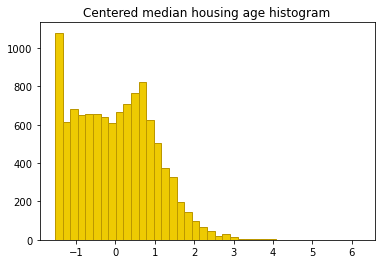

In [405]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(data.c_mileage, bins = 40, color = DARK, edgecolor = DARK_HIGHLIGHT)
axes.set_title("Centered median housing age histogram")

Text(0.5, 1.0, 'Median house value histogram')

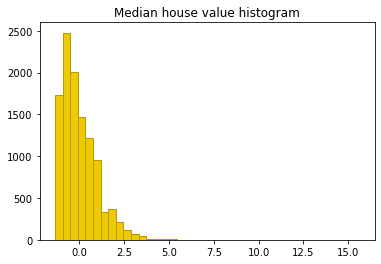

In [406]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(data.price, bins = 40, color = DARK, edgecolor = DARK_HIGHLIGHT)
axes.set_title("Median house value histogram")

Text(0.5, 1.0, 'Median house value on housing median age')

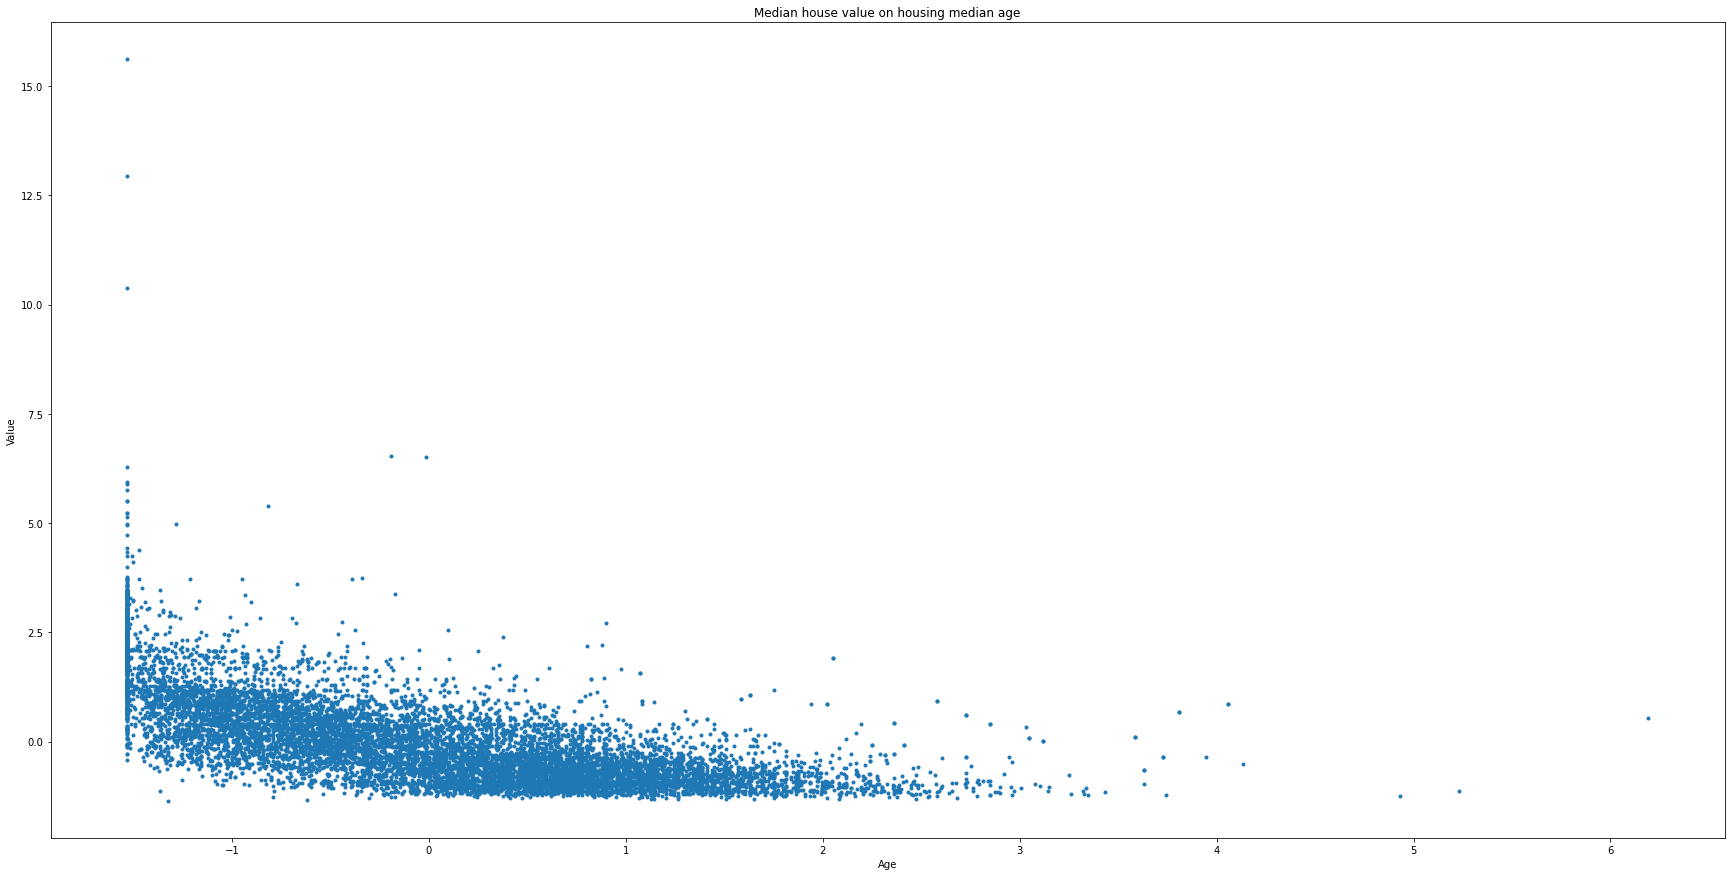

In [412]:
 fig, axes = plt.subplots(1, 1, figsize=(30, 15))
plt.plot(data.mileage, data.price, 'o', markersize=3)
axes.set_xlabel("Age")
axes.set_ylabel("Value")
axes.set_title("Median house value on housing median age")

In [505]:
with open('cost_ppc.stan', 'r') as file: 
    print(file.read())

data { int N;
       real mileage[N];
}
generated quantities {
            real alpha = normal_rng(0,1);
            real beta = normal_rng(0,1);
            real sigma = exponential_rng(0.01);
            real price[N];
            for (i in 1:N) {
              price[i] = normal_rng(mileage[i]*beta+alpha,sigma);
            }
}



In [506]:
model_ppc=CmdStanModel(stan_file='cost_ppc.stan')
R = 1000
data_sim={'N':50, 'mileage':np.linspace(data.c_mileage.min(),data.c_mileage.max())}
sim=model_ppc.sample(data=data_sim,
                        iter_sampling=R, 
                        iter_warmup=0, 
                        chains=1,
                        fixed_param=True, 
                        seed=29042020)

alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc.stan to exe file /Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc.hpp /Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc.stan
Warning in '/Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc.stan', line 2, column 7: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/kamilbaradziej/PythonProjects/DataAnalytics/FinalProject/cost_ppc.stan', line 8, column 12: Declar


INFO:cmdstanpy:CmdStan done processing.


[]

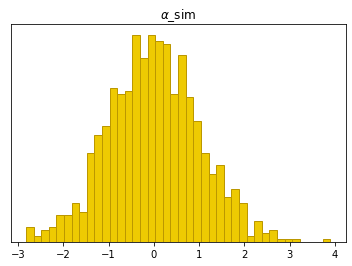

In [507]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(alpha_sim, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\alpha$_sim')
ax.set_yticks(())

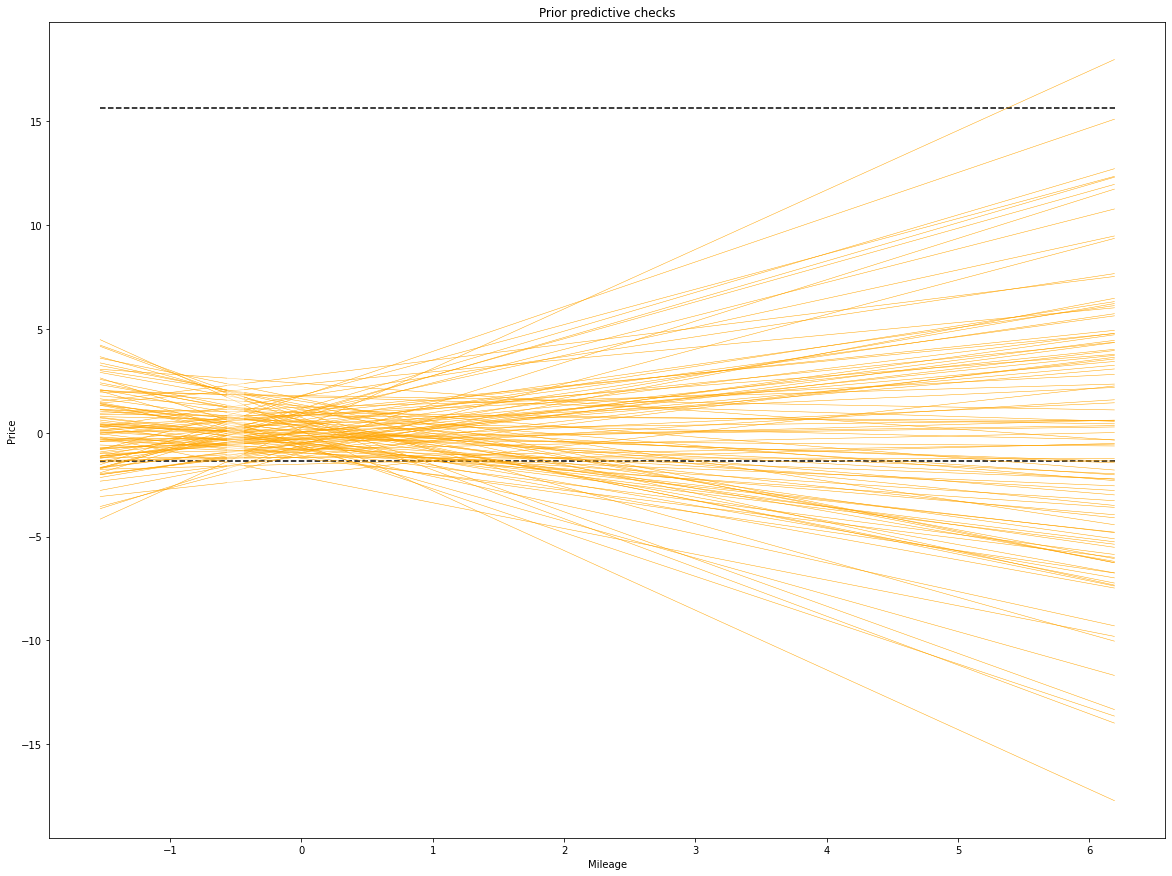

In [508]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.hlines([data.price.min(), data.price.max()],xmin=data.mileage.min(),xmax=data.mileage.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.mileage,alpha_sim[i]+beta_sim[i]*data.c_mileage,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title(r'Prior predictive checks')
plt.show()

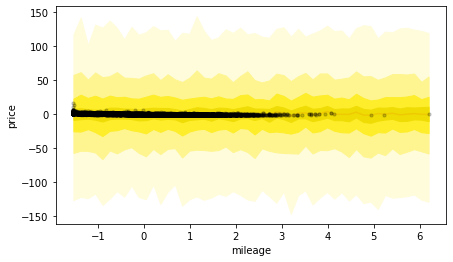

In [509]:
charge_sim=sim.stan_variable('price')
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['mileage']+data.price.mean(),charge_sim,axes)
axes.scatter(data.mileage,data.price,color='black',alpha=0.2,s=10)
axes.set_xlabel('mileage')
axes.set_ylabel('price')
plt.show()

In [510]:
with open('cost_2_fit.stan', 'r') as file: 
    print(file.read())

data { 
    int N;
    vector[N] mileage;
    real price[N];
}

parameters {
            real alpha;
            real beta;
            real<lower=0> sigma;
}
          
transformed parameters {
            vector[N] mu = mileage*beta+alpha;
}

model {
        alpha ~ normal(0,1);
        beta ~ normal(0,1);
        sigma ~ exponential(0.01);
        price ~ normal(mu,sigma);
}

generated quantities {
                    real prices[N];
                    real log_lik[N];
                    for (i in 1:N) {
                      prices[i] = normal_rng(mu[i],sigma);
                      log_lik[i] = normal_lpdf(price[i] | mu[i], sigma);
                    }
}


In [550]:
model_2_fit=CmdStanModel(stan_file='cost_2_fit.stan') 
model_2_fit.compile(force=False)
d_short=data.head(2000)
data_fit=dict(N=len(d_short),
              mileage=d_short.c_mileage.values,
              price=d_short.price.values)
fit=model_2_fit.sample(data=data_fit,seed=28052020)
alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
price_pred=fit.stan_variable('prices')
log_lik=fit.stan_variable('log_lik')
az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status
chain 1 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |████▎                   | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |████▎                   | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |████▎                   | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |██████▌                 | 


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%
alpha,-0.26,0.01,-0.28,-0.24
beta,-0.35,0.01,-0.37,-0.33
sigma,0.43,0.01,0.42,0.45


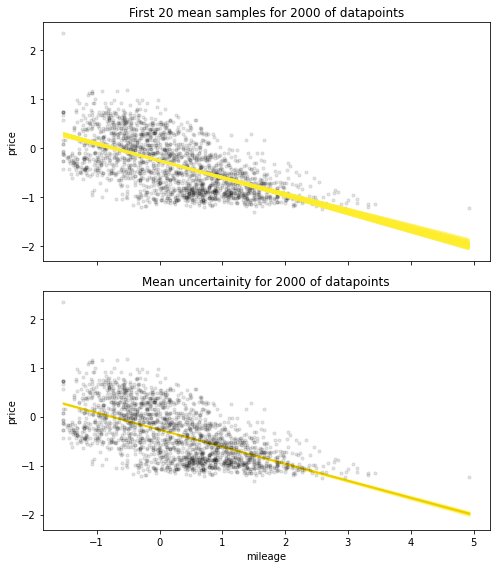

In [551]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True) 
ax0=axes[0]
for i in range(100):
    ax0.plot(d_short.mileage,
              alpha_fit[i]+beta_fit[i]*d_short.c_mileage,
                color=MID,
                alpha=0.5,linewidth=0.5) 
ax0.scatter(d_short.mileage,d_short.price,color='black',alpha=0.1,s=10) 
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short))) 
ax0.set_ylabel('price')
ax1=axes[1]
ax1=ribbon_plot(d_short.mileage.values,mu_fit,ax1,supress_warning=True) 
ax1.scatter(d_short.mileage,d_short.price,color='black',alpha=0.1,s=10) 
ax1.set_xlabel('mileage')
ax1.set_ylabel('price')
ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short))) 
fig.tight_layout()
plt.show()

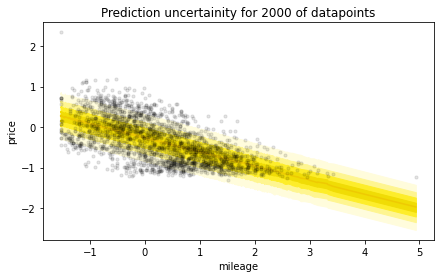

In [552]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.mileage.values,price_pred,axes,supress_warning=True) 
axes.scatter(d_short.mileage,d_short.price,color='black',alpha=0.1,s=10) 
axes.set_xlabel('mileage')
axes.set_ylabel('price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

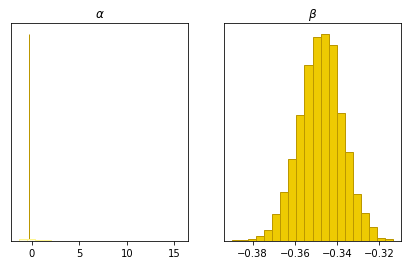

In [553]:
ig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax = axes[0] 
ax.hist(alpha_fit,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax.hist(data.price,bins=20,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True) 
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1] 
ax2.hist(beta_fit,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

Adding second predictor - BMI

In [515]:
# centering variables
data['c_vol_engine'] = data.vol_engine - data.vol_engine.mean()
data['c_mileage'] = data.mileage - data.mileage.mean()
data['c_vol_engine2'] = data.c_vol_engine*data.c_vol_engine
data['c_vol_engine3'] = data.c_vol_engine*data.c_vol_engine*data.c_vol_engine





data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,c_year,c_mileage,c_vol_engine,c_vol_engine2,c_vol_engine3
69639,69639,toyota,auris,gen-ii-2012,2015,-0.434863,0.173747,Hybrid,Warszawa,Mazowieckie,0.270524,0.173747,-0.434863,0.173747,0.030188,0.005245
69640,69640,toyota,auris,gen-ii-2012,2016,-0.139843,-0.260610,Gasoline,Łódź,Łódzkie,0.053394,-0.260610,-0.139843,-0.260610,0.067918,-0.017700
69641,69641,toyota,auris,gen-ii-2012,2015,-0.315874,-0.260610,Gasoline,Radom,Mazowieckie,-0.153517,-0.260610,-0.315874,-0.260610,0.067918,-0.017700
69642,69642,toyota,auris,gen-ii-2012,2018,-0.802183,-0.260610,LPG,Katowice,Śląskie,0.577086,-0.260610,-0.802183,-0.260610,0.067918,-0.017700
69643,69643,toyota,auris,gen-ii-2012,2018,-0.869965,-0.844821,Gasoline,Piaseczno,Mazowieckie,0.002305,-0.844821,-0.869965,-0.844821,0.713722,-0.602967
69644,69644,toyota,auris,gen-ii-2012,2018,-0.582410,0.173747,Hybrid,Janki,Mazowieckie,0.766091,0.173747,-0.582410,0.173747,0.030188,0.005245
69645,69645,toyota,auris,gen-ii-2012,2016,-0.064048,-0.260610,Gasoline,Łódź,Łódzkie,0.053394,-0.260610,-0.064048,-0.260610,0.067918,-0.017700
69646,69646,toyota,auris,gen-ii-2012,2015,-0.072317,-0.844821,Gasoline,Kraków,Małopolskie,-0.102428,-0.844821,-0.072317,-0.844821,0.713722,-0.602967
69647,69647,toyota,auris,gen-ii-2012,2015,-0.882849,-0.260610,Diesel,Warszawa,Mazowieckie,-0.025794,-0.260610,-0.882849,-0.260610,0.067918,-0.017700
69648,69648,toyota,auris,gen-ii-2012,2016,0.524397,-0.260610,Diesel,Kutno,Łódzkie,-0.153517,-0.260610,0.524397,-0.260610,0.067918,-0.017700


In [536]:
with open('cost_3_fit.stan', 'r') as file: 
    print(file.read())

data { int N;
  vector[N] mileage;
  vector[N] vol_engine;
  real price[N];
}

parameters {
  real alpha;
  real beta_mileage;
  real beta_vol_engine;
  real beta_vol_engine2;
  real beta_vol_engine3;


  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = mileage*beta_mileage+vol_engine*beta_vol_engine+(vol_engine^2)*beta_vol_engine2+ +(vol_engine^3)*beta_vol_engine3 +alpha;
}

model {
  alpha ~ normal(0,1);
  beta_mileage ~ normal(0,1);
  beta_vol_engine ~ normal(0, 1);
  sigma ~ exponential(0.01);
  price ~ normal(mu,sigma);
}

generated quantities {
  real prices[N];
  real log_lik[N];
  for (i in 1:N) {
    prices[i] = normal_rng(mu[i],sigma);
    log_lik[i] = normal_lpdf(price[i] | mu[i], sigma);
  }
}


In [544]:
model_3_fit=CmdStanModel(stan_file='cost_3_fit.stan') 
model_3_fit.compile(force=False)
d_short=data.head(2000)
data_fit=dict(N=len(d_short),
              mileage=d_short.c_mileage.values,
              vol_engine=d_short.c_vol_engine.values,
              price=d_short.price.values)

fit_2 = model_3_fit.sample(data=data_fit,seed=28052020)
alpha_fit = fit_2.stan_variable('alpha')
beta_mileage_fit = fit_2.stan_variable('beta_mileage')
beta_vol_engine_fit = fit_2.stan_variable('beta_vol_engine')
beta_vol_engine_fit2 = fit_2.stan_variable('beta_vol_engine2')
beta_vol_engine_fit3 = fit_2.stan_variable('beta_vol_engine3')


mu_fit_2 = fit_2.stan_variable('mu')
price_pred_2 = fit_2.stan_variable('prices')
log_lik = fit_2.stan_variable('log_lik')
az.summary(fit_2,var_names=['alpha','beta_mileage','beta_vol_engine','sigma'],round_to=2,kind='stats')
# Values are standarized so we can see that Age variable is much more important by looking at mean for both betas in
#summary below

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status


chain 4 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |██▏                     | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |███▎                    | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███▎                    | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███▎                    | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |████▎                   | 


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%
alpha,-0.06,0.01,-0.09,-0.05
beta_mileage,-0.45,0.01,-0.47,-0.43
beta_vol_engine,0.23,0.02,0.19,0.28
sigma,0.34,0.01,0.33,0.36


In [545]:
log_lik

array([[ 0.0799621 ,  0.0571514 ,  0.0387792 , ...,  0.0864634 ,
        -0.0199178 ,  0.107936  ],
       [ 0.0999357 ,  0.0752879 ,  0.0481975 , ..., -0.00741521,
         0.100874  ,  0.149629  ],
       [ 0.108601  ,  0.062237  ,  0.0693871 , ...,  0.08278   ,
         0.0395628 ,  0.141671  ],
       ...,
       [ 0.0994544 ,  0.0779574 ,  0.053911  , ...,  0.0648372 ,
         0.0745127 ,  0.148395  ],
       [ 0.114084  ,  0.0819654 ,  0.0392472 , ...,  0.0479694 ,
         0.0451961 ,  0.14561   ],
       [ 0.109231  ,  0.0890812 ,  0.0475879 , ...,  0.0516788 ,
         0.0844052 ,  0.155284  ]])

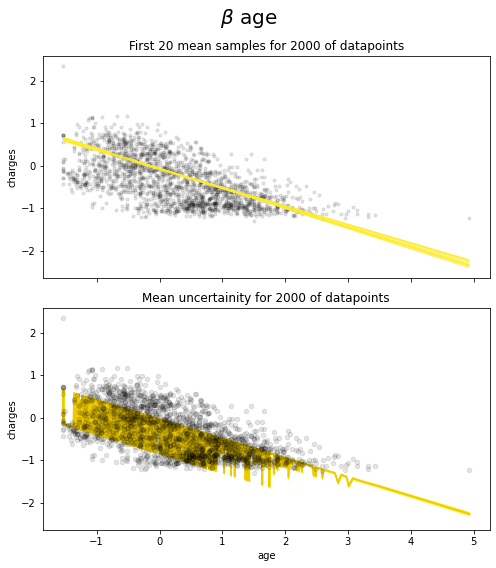

In [546]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True) 
ax0=axes[0]
for i in range(20):
    ax0.plot(d_short.mileage,
              alpha_fit[i]+beta_mileage_fit[i]*d_short.c_mileage,
              color=MID,
              alpha=0.5,linewidth=0.5)
ax0.scatter(d_short.mileage,d_short.price,color='black',alpha=0.1,s=10) 
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short))) 
fig.suptitle(r'$\beta$ age', fontsize=20)
ax0.set_ylabel('charges')
ax1=axes[1] 
ax1=ribbon_plot(d_short.mileage.values,mu_fit_2,ax1,supress_warning=True) 
ax1.scatter(d_short.mileage,d_short.price,color='black',alpha=0.1,s=20) 
ax1.set_xlabel('age')
ax1.set_ylabel('charges')
ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short))) 
fig.tight_layout()
plt.show()

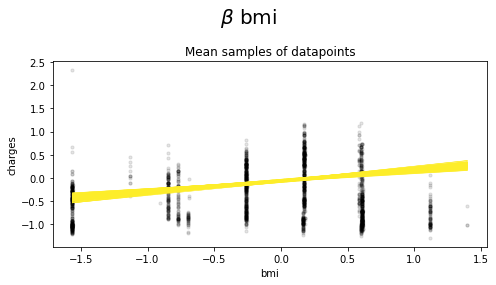

In [547]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True) 
for i in range(459):
    axes.plot(d_short.vol_engine,
              alpha_fit[i]+beta_vol_engine_fit[i]*d_short.c_vol_engine,
              color=MID,
              alpha=0.5,linewidth=0.5)
axes.scatter(d_short.vol_engine,d_short.price,color='black',alpha=0.1,s=10)
axes.set_title('Mean samples of datapoints'.format(len(d_short)))
fig.suptitle(r'$\beta$ bmi', fontsize=20)
axes.set_ylabel('charges')
axes.set_xlabel('bmi')
fig.tight_layout()
plt.show()
# beta for BMI parameter is very close to 0 and insignificant

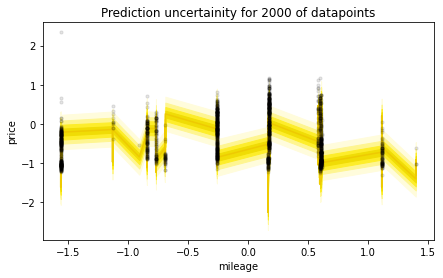

In [548]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.vol_engine.values,price_pred_2,axes,supress_warning=True) 
axes.scatter(d_short.vol_engine,d_short.price,color='black',alpha=0.1,s=10) 
axes.set_xlabel('mileage')
axes.set_ylabel('price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

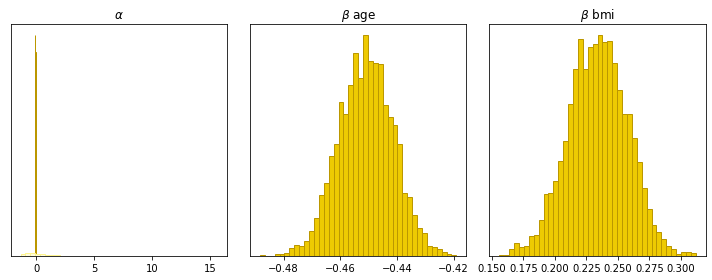

In [549]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax = axes[0] 
ax.hist(alpha_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax.hist(data.price,bins=40,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True) 
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1] 
ax2.hist(beta_mileage_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$ age')
ax2.set_yticks(())
fig.tight_layout()
ax2 = axes[2] 
ax2.hist(beta_vol_engine_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$ bmi')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

Comparing models

In [554]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = fit, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = fit_2, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "loo") # loo stands for leave one out cross validation

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-709.618436,5.975831,0.000000,0.999508,39.172315,0.000000,False,log
model_1,1,-1168.515405,2.616884,458.896969,0.000492,28.978487,29.568691,False,log


In [451]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = fit, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = fit_2, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-20.667440,4.371725,0.000000,0.916834,15.666595,0.000000,False,log
model_1,1,-89.117251,2.716857,68.449811,0.083166,13.677155,12.060397,False,log


<AxesSubplot:xlabel='Log'>

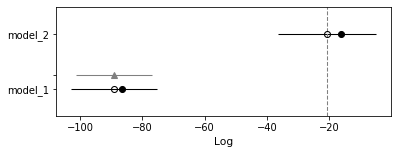

In [452]:
az.plot_compare(az.compare(compare_dict))
